### Look at the result of GLMs including value terms vs. not. 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)

In [2]:
OUTPUT_DIR = "/data/patrick_res/glm_2"
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)

### Look at deviance explained as a func of time
take a look at a few example units

Compare 99th percentile shuffled, 50th percentile shuffled, to value GLM

In [3]:
session = 20180803
value_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_{MODE}_{INTERVAL_SIZE}_{MODEL}_values.pickle"))
value_res["TimeIdxs"] = (value_res["TimeBins"] * 20).astype(int)
value_res = value_res.rename(columns={"score": "value_score"})

shuffled_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_{MODE}_{INTERVAL_SIZE}_{MODEL}_value_shuffles.pickle"))        
shuffled_res["TimeIdxs"] = (shuffled_res["TimeBins"] * 20).astype(int)

sig_stats = glm_utils.calculate_sig_stats(shuffled_res, 0.01, 1)
sig_stats["TimeIdxs"] = (sig_stats["TimeBins"] * 20).astype(int)

FileNotFoundError: [Errno 2] No such file or directory: '/data/patrick_res/glm_2/20180803_glm_FiringRate_50_Linear_value_shuffles.pickle'

In [ ]:
positions = spike_utils.get_unit_positions_per_sess(session)
positions = positions.fillna("unknown")
positions = spike_utils.get_manual_structure(positions)

NameError: name 'session' is not defined

In [5]:
merged = pd.merge(value_res, sig_stats, on=["UnitID", "TimeIdxs"])


NameError: name 'value_res' is not defined

In [ ]:
for unit in merged.UnitID.unique():
    fig, ax = plt.subplots()
    unit_res = merged[merged.UnitID == unit]
    times = unit_res.TimeBins_x - 1.3
    ax.plot(times, unit_res.value_score, label="Value")
    ax.plot(times, unit_res.sig_bound, label="Sig Bound")

    region = positions[positions.UnitID == unit].manual_structure.values[0]
    ax.set_title(f"Unit {unit} ({region})")
    ax.legend()

### Look at firing rates of some units

In [37]:
SESS_BEHAVIOR_PATH = "/data/rawdata/sub-SA/sess-{sess_name}/behavior/sub-SA_sess-{sess_name}_object_features.csv"

# PRE_INTERVAL = 1300
# POST_INTERVAL = 1500
# INTERVAL_SIZE = 50
# SMOOTH = 1
# EVENT = "FeedbackOnset"

PRE_INTERVAL = 500
POST_INTERVAL = 500
INTERVAL_SIZE = 50
SMOOTH = 1
EVENT = "FixationOnCross"

FEATURE_DIMS = ["Color", "Shape", "Pattern"]

In [38]:
def plot_features_frs_for_unit(unit_row):
    session = unit_row.session
    unit_id = unit_row.UnitID

    behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    valid_beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(valid_beh)
    valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber")
    valid_beh_rpes = behavioral_utils.get_rpe_groups_per_session(session, valid_beh)
    fr_path = f"/data/patrick_res/firing_rates/{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{SMOOTH}_smooth.pickle"
    frs = pd.read_pickle(fr_path)

    pos = spike_utils.get_unit_positions_per_sess(session)
    pos = pos.fillna("unknown")
    pos = spike_utils.get_manual_structure(pos)

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    group_names = FEATURE_DIMS + ["RPEGroup"]
    # print(session)
    for i, group_name in enumerate(group_names):
        group_colors = None
        if group_name == "RPEGroup":
            group_colors = {
                "more pos": "#024dfa",
                "less pos": "#86a8f7",
                "less neg": "#fa8c91",
                "more neg": "#fa000b",
            }
        visualization_utils.plot_mean_frs_by_group(session, unit_id, frs, valid_beh_rpes, group_name, pos, axs[i], mode="FiringRate", group_colors=group_colors)



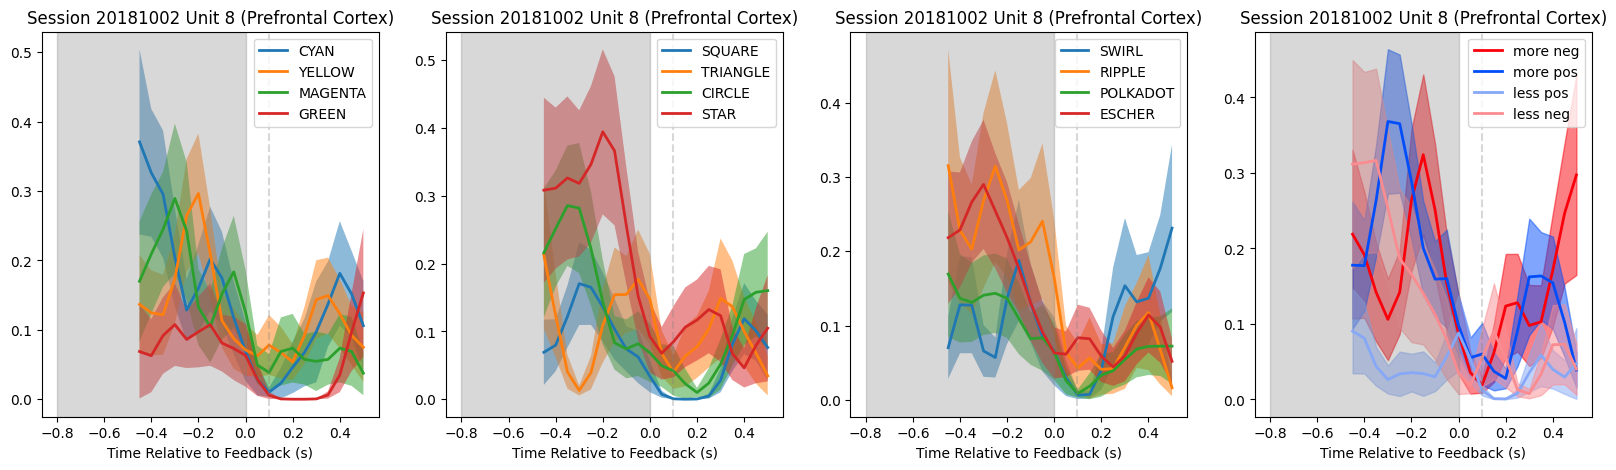

In [39]:
pseudo_unit_id = 2018100208
positions = spike_utils.get_unit_positions(sessions)
unit_row = positions[positions.PseudoUnitID == pseudo_unit_id].iloc[0]
plot_features_frs_for_unit(unit_row)

### Check firing rates for different values

In [5]:
SESS_BEHAVIOR_PATH = "/data/rawdata/sub-SA/sess-{sess_name}/behavior/sub-SA_sess-{sess_name}_object_features.csv"

# PRE_INTERVAL = 1300
# POST_INTERVAL = 1500
# INTERVAL_SIZE = 50
# SMOOTH = 1
# EVENT = "FeedbackOnset"

PRE_INTERVAL = 500
POST_INTERVAL = 500
INTERVAL_SIZE = 50
SMOOTH = 1
EVENT = "FixationOnCross"

FEATURE_DIMS = ["Color", "Shape", "Pattern"]

In [6]:
positions = spike_utils.get_unit_positions(sessions)

In [7]:
threshold = 0.1
def plot_unit_by_feature_value(unit_row, feature, ax):
    session = unit_row.session
    unit_id = unit_row.UnitID

    behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    valid_beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(valid_beh)
    valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber", how="inner")
    beh = behavioral_utils.get_feature_values_per_session(session, valid_beh)
    beh["PrevResponse"] = beh.Response.shift()
    feature_dim = FEATURE_TO_DIM[feature]
    beh[f"Prev{feature_dim}"] = beh[feature_dim].shift()
    # beh = beh[beh["PrevResponse"] == "Correct"]
    # beh = beh[beh[f"Prev{feature_dim}"] == feature]

    # print(f"{feature} {len(beh)}")
    
    beh["ValueGroup"] = beh[feature + "Value"] > threshold
    beh["ValueGroup"] = feature + beh["ValueGroup"].astype(str)
    pos = spike_utils.get_unit_positions_per_sess(session)
    pos = pos.fillna("unknown")
    pos = spike_utils.get_manual_structure(pos)

    fr_path = f"/data/patrick_res/firing_rates/{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{SMOOTH}_smooth.pickle"
    # fr_path = f"/data/patrick_res/firing_rates/{session}_residual_feature_Response_with_interaction_prev_trial_params_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{SMOOTH}_smooth.pickle"
    frs = pd.read_pickle(fr_path)


    visualization_utils.plot_mean_frs_by_group(session, unit_id, frs, beh, "ValueGroup", pos, ax, mode="FiringRate", set_ax=False)
    unit_pos = pos[pos.UnitID == unit_id].structure_level2.unique()[0]
    ax.set_title(f"{unit_row.PseudoUnitID} ({unit_pos})")
    ax.set_xlabel("Time Relative to cross fixation (s)")

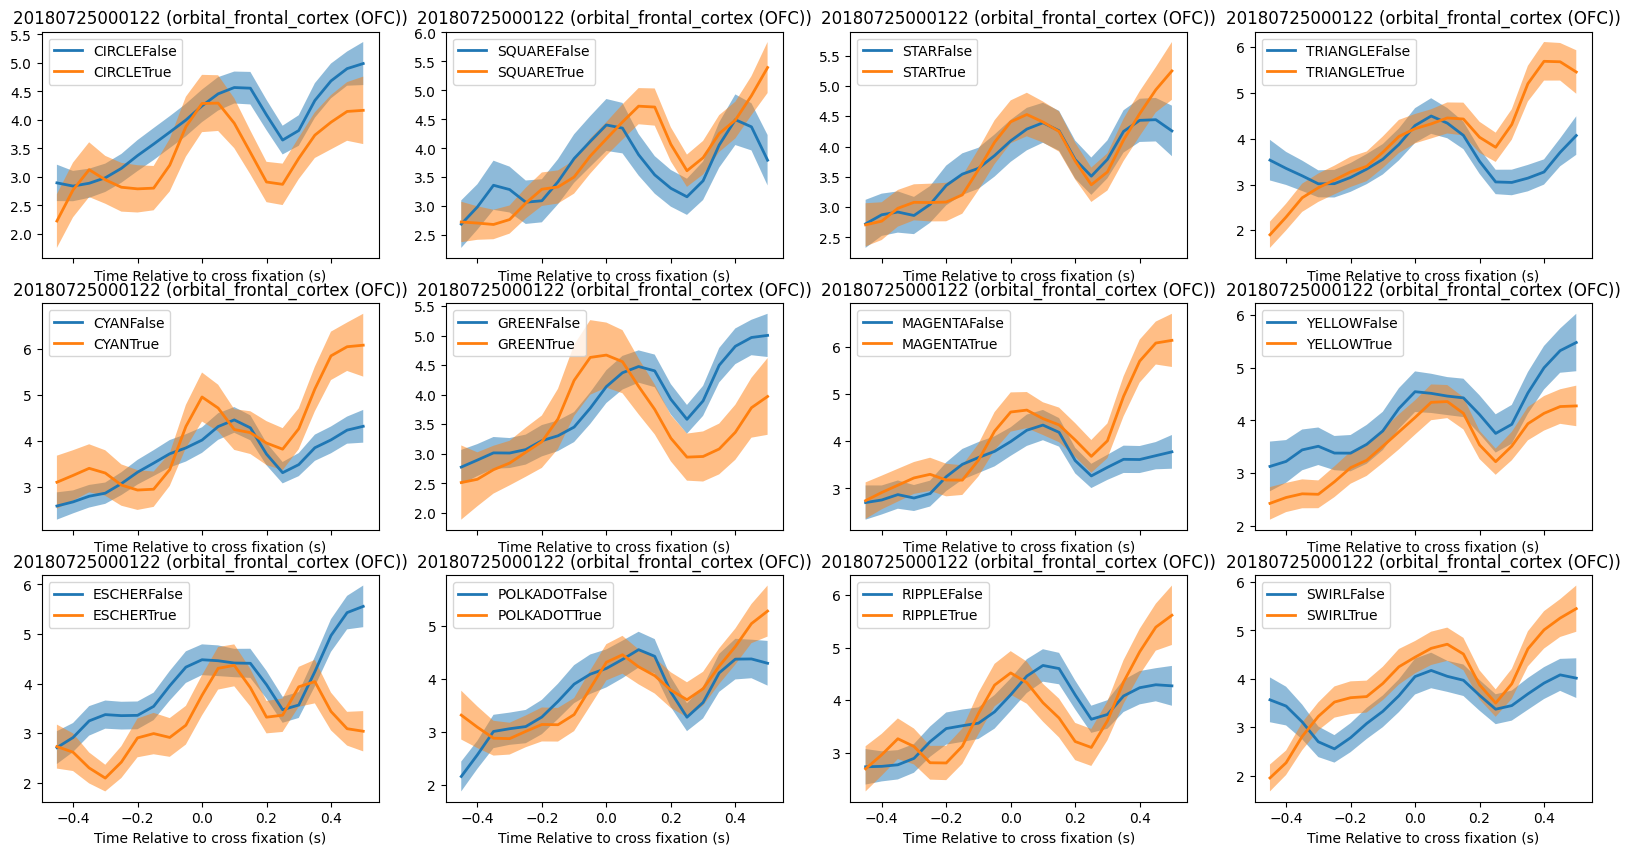

In [8]:
# # pseudo_unit_id = 2018092006
# # pseudo_unit_id = 2018080611
# # pseudo_unit_id = 2018071238
# pseudo_unit_id = 2018092012
# # pseudo_unit_id = 2018100217
# # pseudo_unit_id = 2018100201
# # pseudo_unit_id = 2018071238
# # pseudo_unit_id = 2018100220
# # pseudo_unit_id = 2018092012
# # pseudo_unit_id = 2018092414
# pseudo_unit_id = 2018080817
pseudo_unit_id = 20180725000122
unit_row = positions[positions.PseudoUnitID == pseudo_unit_id].iloc[0]
fig, axs = plt.subplots(3, 4, figsize=(20, 10), sharex=True)
for i, feature in enumerate(FEATURES):
    ax = axs[int(i / 4), i % 4]
    plot_unit_by_feature_value(unit_row, feature, ax)
# hip_units = positions[positions.structure_level3 == "hippocampal_formation (HF)"]
# for pseudo_unit_id in hip_units.PseudoUnitID.unique():
#     unit_row = positions[positions.PseudoUnitID == pseudo_unit_id].iloc[0]
#     fig, axs = plt.subplots(3, 4, figsize=(20, 10), sharex=True)
#     for i, feature in enumerate(FEATURES):
#         ax = axs[int(i / 4), i % 4]
#         plot_unit_by_feature_value(unit_row, feature, ax)

### Plot some raster plots

In [24]:
def plot_raster(unit, spike_times, beh, order_col, group_name, group_colors, group_ordering, ax):
    group_offset = 0
    unit_spikes = spike_times[spike_times.UnitID == unit]
    for group in group_ordering:
        group_beh = beh[beh[group_name] == group].sort_values(by=order_col, ascending=False)
        group_beh["Y"] = np.arange(len(group_beh)).astype(int) + group_offset
        group_offset += len(group_beh)
        spikes = pd.merge(unit_spikes, group_beh, on="TrialNumber")
        spikes["X"] = (spikes.SpikeTimeFromStart - PRE_INTERVAL) / 1000
        ax.scatter(spikes.X, spikes.Y, marker="_", linewidths=1.5, label=group, s=3, color=group_colors[group])

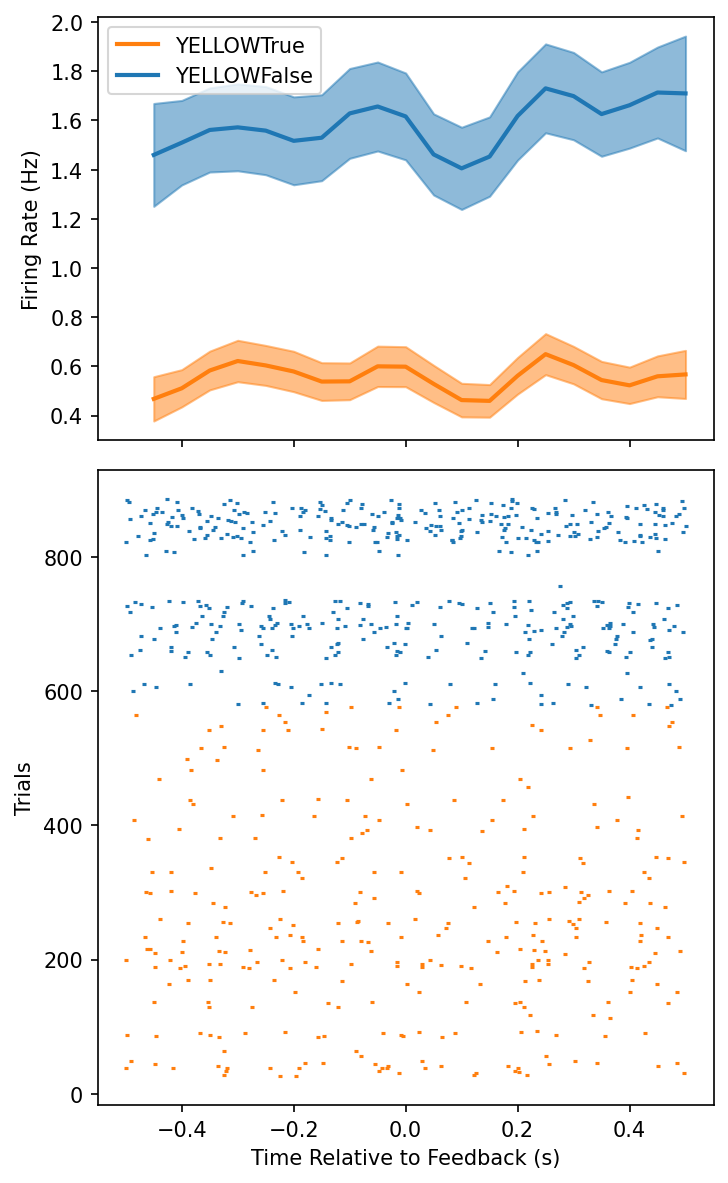

In [25]:
unit_row = positions[positions.PseudoUnitID == pseudo_unit_id].iloc[0]
feature = "YELLOW"

session = unit_row.session
unit_id = unit_row.UnitID

behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
beh = pd.read_csv(behavior_path)

# filter trials 
valid_beh = behavioral_utils.get_valid_trials(beh)
feature_selections = behavioral_utils.get_selection_features(valid_beh)
valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber", how="inner")
beh = behavioral_utils.get_feature_values_per_session(session, valid_beh)

beh["PrevResponse"] = beh.Response.shift()
feature_dim = FEATURE_TO_DIM[feature]
beh[f"Prev{feature_dim}"] = beh[feature_dim].shift()
# beh = beh[beh["PrevResponse"] == "Correct"]
# beh = beh[beh[f"Prev{feature_dim}"] == feature]

beh["ValueGroup"] = beh[feature + "Value"] > threshold
beh["ValueGroup"] = feature + beh["ValueGroup"].astype(str)
pos = spike_utils.get_unit_positions_per_sess(session)
pos = pos.fillna("unknown")
pos = spike_utils.get_manual_structure(pos)

fr_path = f"/data/patrick_res/firing_rates/{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{SMOOTH}_smooth.pickle"
frs = pd.read_pickle(fr_path)

SUBJECT = "SA"
spike_times = spike_general.get_spike_times(None, SUBJECT, session, species_dir="/data")
intervals = behavioral_utils.get_trial_intervals(valid_beh, EVENT, PRE_INTERVAL, POST_INTERVAL)
spike_by_trial_interval = spike_utils.get_spikes_by_trial_interval(spike_times, intervals)
spike_by_trial_interval.TrialNumber = spike_by_trial_interval.TrialNumber.astype(int)

group_name = "ValueGroup"
group_colors = {
    feature + "False": "tab:blue", 
    feature + "True": "tab:orange", 
}
# group_ordering = ["POLKADOT", "SWIRL", "ESCHER", "RIPPLE"]
group_ordering = [feature + "True", feature + "False"]

fig, axs = plt.subplots(2, 1, figsize=(5, 8), gridspec_kw={'height_ratios': [4, 6]}, sharex=True, dpi=150)

ax = axs[0]
visualization_utils.plot_mean_frs_by_group(
    session, unit_id, frs, beh, group_name, pos, ax, 
    mode="FiringRate", group_colors=group_colors, group_order=group_ordering, set_ax=False
)
ax.set_ylabel("Firing Rate (Hz)")
ax = axs[1]
plot_raster(unit_id, spike_by_trial_interval, beh, feature + "Value", group_name, group_colors, group_ordering, ax)    
ax.set_ylabel("Trials")
ax.set_xlabel("Time Relative to Feedback (s)")
fig.tight_layout()

### Scrap

In [5]:
df = pd.read_csv("/data/082023_Feat_RLDE_HV/sess-20180802_hv.csv")

In [8]:
df

,trial,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11
0,35,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,36,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,37,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,38,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,39,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1702,1738,0.130760,0.181514,0.007635,0.218069,-0.017239,0.540891,-0.000036,-0.131027,0.193760,0.032039,0.110023,0.196207
1703,1739,0.126029,0.174946,0.007359,0.245983,-0.016615,0.568805,-0.000035,-0.126286,0.186749,0.030880,0.137937,0.189108
1704,1740,0.121469,0.168616,0.057369,0.237082,-0.016014,0.618815,-0.000034,-0.121716,0.179992,0.029762,0.132946,0.239118
1705,1741,0.117074,0.162515,0.075414,0.228504,-0.015434,0.636860,-0.000033,-0.117312,0.173479,0.028685,0.128135,0.257163
